In [63]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




         Status Application Creation Date Approved / Refused Date  \
15192   Refused                2008-04-28              30/04/2010   
9636    Expired                2009-01-06              26/08/2009   
10589  Recorded                2009-01-10              16/10/2009   
11781  Recorded                2009-01-10              05/10/2009   
2043   Recorded                2009-01-10              09/10/2009   
...         ...                       ...                     ...   
10747  Recorded                2024-12-02              22/02/2024   
8195   Recorded                2024-12-03              16/04/2024   
16325  Recorded                2024-12-03              04/04/2024   
544    Recorded                2024-12-03              21/03/2024   
6287   Recorded                2024-12-04              16/04/2024   

      Recorded / Rejected Date Water Share ID Water System Source Reliability  \
15192               30/04/2010      WEE****03            Goulburn        High   
9636     

## Function Dec

In [64]:
import pandas as pd
from sklearn.impute import SimpleImputer

def process_and_combine_data(file_path, merge_data=None, merge_on=('Create_date_ordinal', 'Time_ordinal'), row_thresh_multiplier=0.5):
    # Load the data
    tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')
    print("Array size:", tempData.shape)
    # Drop rows where more than half the columns have missing values
    row_thresh = len(tempData.columns) * row_thresh_multiplier
    tempData = tempData.dropna(axis=0, thresh=row_thresh)
    print("Array size:", tempData.shape)
    # Drop any columns with missing values
    tempData = tempData.dropna(axis=1, how='any')
    print("Array size:", tempData.shape)

    # Group data by 'Time', calculate the mean, and reset the index
    daily_tempData = tempData.groupby(tempData.index).mean().reset_index()
    daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

    return daily_tempData
    # If merge data is provided, merge it on the specified columns
    if merge_data is not None and merge_on:
        combined_data = pd.merge(merge_data, daily_tempData, left_on=merge_on[0], right_on=merge_on[1], how='inner')
        # Export the combined data to a CSV file
        combined_data.to_csv('combined_data.csv', index=False)
        return combined_data



# Water Temp

Array size: (10227, 402)
Array size: (4281, 402)
Array size: (4281, 7)
['226227', '235211', '409002', '409014', '409023', '409036', '409061']
Explained Variance Ratio: [0.8716016  0.10198781]


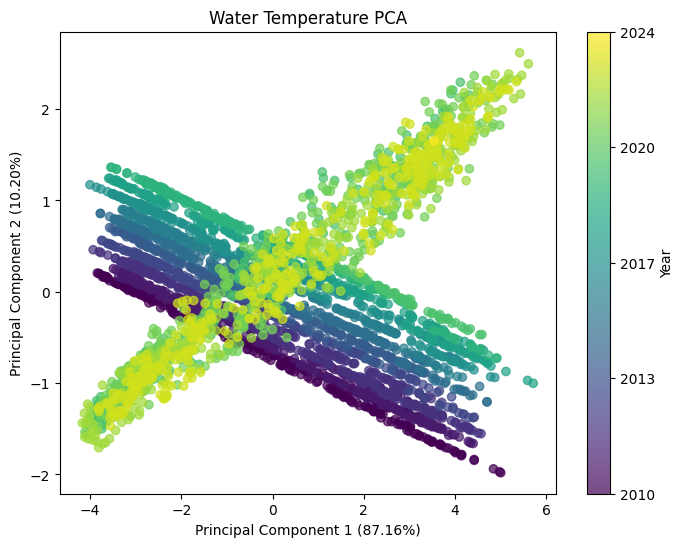

Explained Variance Ratio: [0.8716016  0.10198781]
      principal component 1  principal component 2
0                  4.418263              -1.836298
1                  4.011774              -1.751523
2                  3.304455              -1.589807
3                  3.157669              -1.554838
4                  3.403523              -1.619428
...                     ...                    ...
4276               3.731673               1.785217
4277               3.549289               1.482924
4278               3.297425               1.388059
4279               3.171738               1.381866
4280               3.537980               1.650768

[4281 rows x 2 columns]


In [65]:


# Example usage:
Water_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
combined_data = process_and_combine_data(Water_temp_file_path, merge_data=zone_data_1A_top_sorted)

# Export the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Water Temperature PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# Trade off between spacial and temporal patterns

Temporal Trends: If the focus is on understanding how patterns evolve over time or capturing seasonal variations and long-term trends, having a longer time period with data from fewer stations might be more beneficial.
Spatial Patterns: If the goal is to compare spatial variations or the behavior across different locations, then analyzing more stations over a shorter period might provide more insights into spatial differences.

# Turbidity

Array size: (5114, 118)
Array size: (303, 118)
Array size: (303, 29)
['221224', '222201', '224217', '225209', '226017', '226027', '226227', '232204', '232210', '233217', '234201', '237205', '238206', '401549', '403241', '404216', '405240', '405257', '41001701', '41001702', '410134', '410729', '410733', '410747', '410761', '410774', '410777', '410781', '415608']
Explained Variance Ratio: [0.17750039 0.10966792]


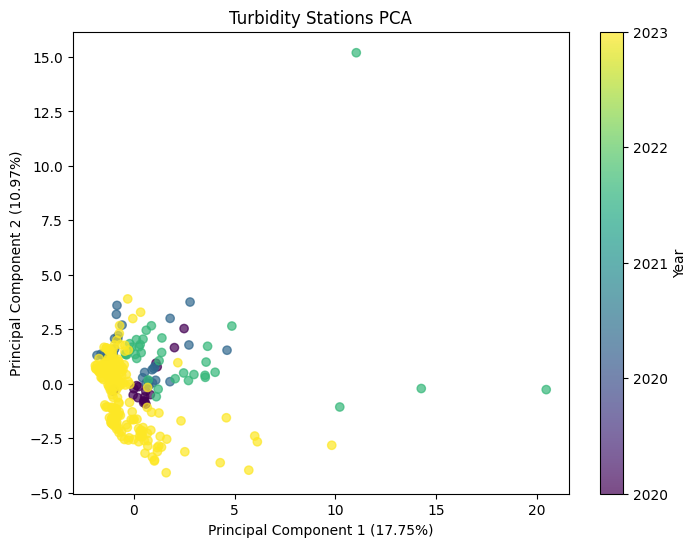

Explained Variance Ratio: [0.17750039 0.10966792]
     principal component 1  principal component 2
0                 2.491620               2.531892
1                 0.817918              -0.501575
2                 0.534924              -0.605824
3                 0.193564              -0.640169
4                -0.036180              -0.520052
..                     ...                    ...
298              -0.219175              -0.860208
299              -0.604515               0.377486
300              -0.573003               0.753316
301              -0.621394               0.539740
302              -0.876263               0.084871

[303 rows x 2 columns]


In [66]:
# Example usage:
Turbidity_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTurbidity.csv'
combined_data = process_and_combine_data(Turbidity_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.56)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Turbidity Stations PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# Dry Air

Array size: (7007, 14)
Array size: (811, 14)
Array size: (811, 6)
['219027', '410102', '570818', '570825', '570947', 'ST514A']
Explained Variance Ratio: [0.5906079  0.16183106]


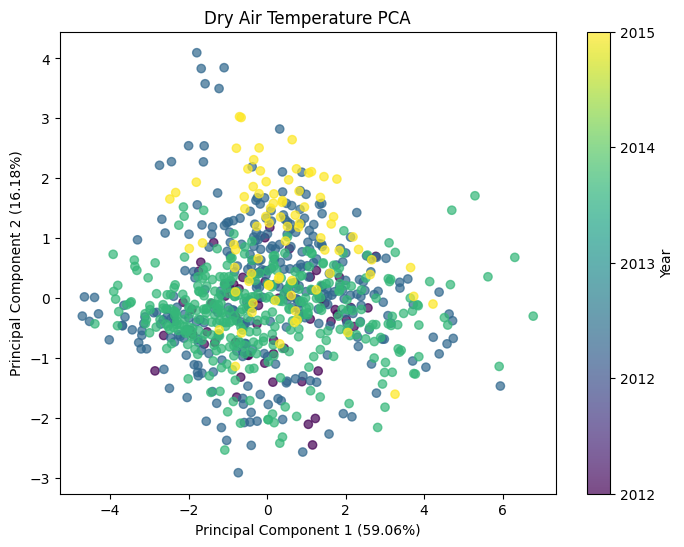

Explained Variance Ratio: [0.5906079  0.16183106]
     principal component 1  principal component 2
0                -0.674008              -1.321824
1                -1.897150              -0.605922
2                -1.414558              -0.090656
3                -0.258994              -0.435740
4                -1.531401              -0.565194
..                     ...                    ...
806               0.040699               0.209719
807              -0.361388              -0.085464
808              -0.805595               0.100563
809               0.208339              -0.042538
810              -1.220788              -0.532726

[811 rows x 2 columns]


In [67]:
# Example usage:
DryAir_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanDryAir.csv'
combined_data = process_and_combine_data(DryAir_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Dry Air Temperature PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# EC

Array size: (10227, 311)
Array size: (3465, 311)
Array size: (3465, 7)
['234200', '409002', '409023', '409061', '409062', '409086', '410781']
Explained Variance Ratio: [0.27960983 0.18903968]


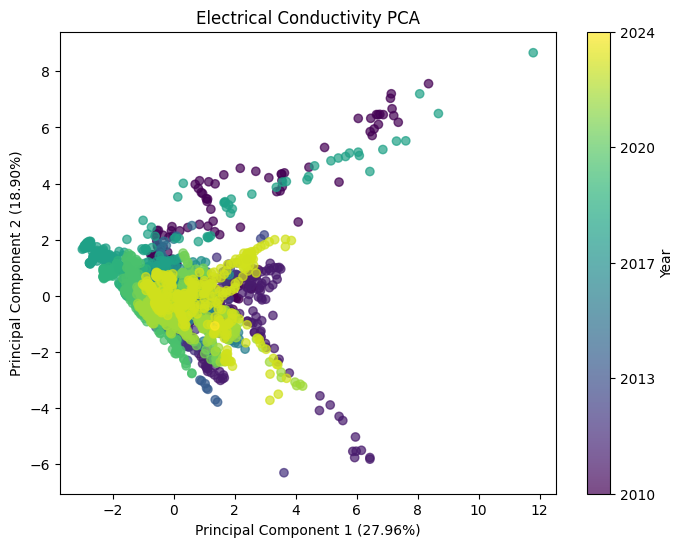

Explained Variance Ratio: [0.27960983 0.18903968]
      principal component 1  principal component 2
0                  0.015217               0.580642
1                  0.010098               0.533567
2                 -0.074553               0.519199
3                  0.092221               0.614241
4                  0.124712               0.298535
...                     ...                    ...
3460               2.362396              -1.672433
3461               3.156093              -2.787217
3462               3.426873              -3.503919
3463               3.151723              -3.719937
3464               1.343088              -1.070942

[3465 rows x 2 columns]


In [68]:
# Example usage:
EC_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyEC.csv'
combined_data = process_and_combine_data(EC_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Electrical Conductivity PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# RainFall

Array size: (14001, 725)
Array size: (5114, 725)
Array size: (5114, 27)
['00009', '215014', '225201', '225218', '226216', '226415', '231211', '233803', '234201', '237207', '403805', '410535', '570801', '570813', '570967', '570991', 'sp-o10109', 'sp-o10138', 'sp-o10350', 'sp-o10438', 'sp-o10606', 'sp-o10814', 'sp-o10926', 'sp-o10930', 'sp-o11430', 'sp-o11454', 'sp-o11590']
Explained Variance Ratio: [0.34056559 0.1155597 ]


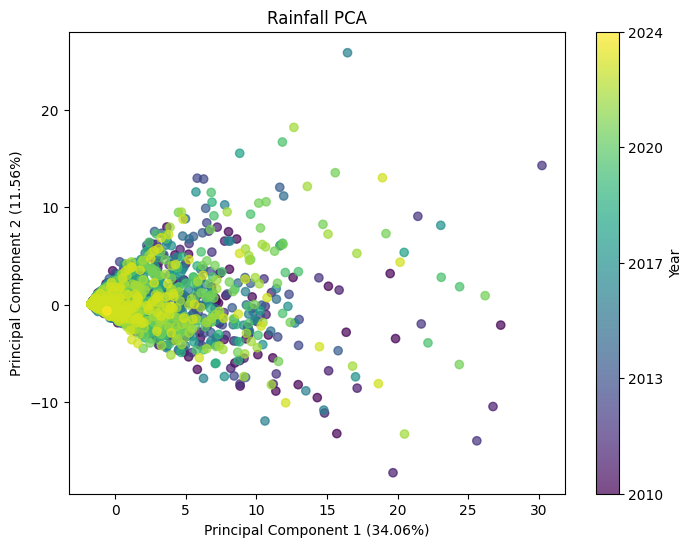

Explained Variance Ratio: [0.34056559 0.1155597 ]
      principal component 1  principal component 2
0                  8.479730              -5.982020
1                  2.741073              -0.445065
2                 -1.653418               0.171352
3                 -1.659946               0.138775
4                 -1.523726               0.379898
...                     ...                    ...
5109              -0.931549              -0.413811
5110              -1.013617              -0.391170
5111              -0.887163              -0.430235
5112              -0.667771              -0.486708
5113              -0.576228              -0.627862

[5114 rows x 2 columns]


In [69]:
# Example usage:
Rainfall_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyRainfall.csv'
combined_data = process_and_combine_data(Rainfall_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Rainfall PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# WaterCourse

Array size: (14000, 1360)
Array size: (5114, 1360)
Array size: (5114, 216)
['2122711', '215002', '215007', '215014', '215208', '215239', '217006', '218001', '218005', '218007', '219003', '219017', '219022', '219025', '219032', '220003', '220004', '221201', '221208', '221209', '221210', '221212', '221224', '222007', '222008', '222017', '222019', '222200', '222202', '222206', '222219', '222522', '222541', '223202', '223204', '223205', '223214', '224201', '224203', '224217', '225201', '225209', '225212', '225218', '225219', '225231', '225232', '226007', '226023', '226209', '226224', '226228', '226402', '227202', '227211', '227213', '227219', '227226', '227237', '228203C', '228204C', '228209B', '228212A', '228217C', '228225A', '228228A', '228229B', '228231A', '228235A', '228351B', '228356B', '228357A', '228362A', '228368A', '228380A', '228382A', '228393A', '229109A', '229135A', '229144A', '229149A', '229200B', '229206A', '229212A', '229249A', '229257A', '229270A', '229272A', '229403A', '22

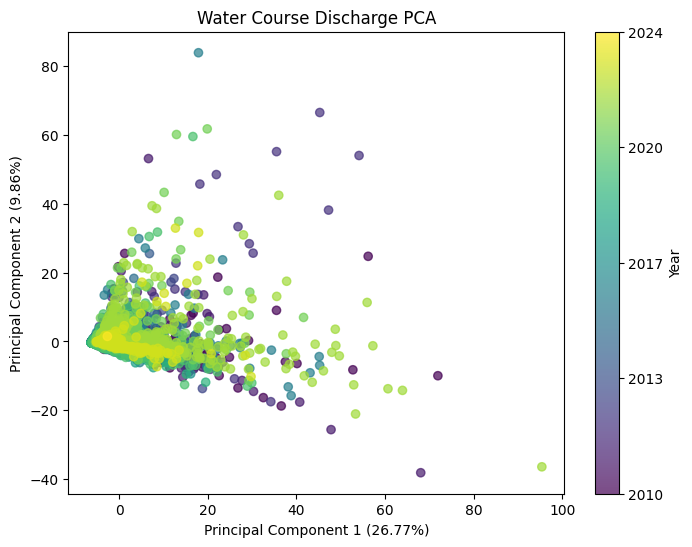

Explained Variance Ratio: [0.26772685 0.09862906]
      principal component 1  principal component 2
0                 -3.270982              -1.649389
1                 -2.340138              -1.538397
2                 -3.244419              -1.173933
3                 -4.608783              -0.673105
4                 -5.110213              -0.524071
...                     ...                    ...
5109               4.857152               8.129639
5110               1.180129               4.569160
5111              -0.833903               2.988757
5112              -1.975836               1.987110
5113              -2.649986               1.468455

[5114 rows x 2 columns]


In [70]:
# Example usage:
WaterCourse_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanWaterCourseDischarge.csv'
combined_data = process_and_combine_data(WaterCourse_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Water Course Discharge PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# SARIMA

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


WATERTEMP = pd.read_csv(Water_temp_file_path, parse_dates=['Time'], index_col='Time')
#TURBIDITY = pd.read_csv(Turbidity_temp_file_path, parse_dates=['Time'], index_col='Time')
#AIRTEMP = pd.read_csv(DryAir_temp_file_path, parse_dates=['Time'], index_col='Time')
RAINFALL = pd.read_csv(Rainfall_temp_file_path, parse_dates=['Time'], index_col='Time')
WATERCOURSE = pd.read_csv(WaterCourse_temp_file_path, parse_dates=['Time'], index_col='Time')
#ELECTRICALCOND = pd.read_csv(EC_temp_file_path, parse_dates=['Time'], index_col='Time')


ZONEDATA = zone_data_7_top_sorted


from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Assuming 'principal component 1' as the target series
test_stationarity(ZONEDATA['principal component 1'])


In [72]:
# Combine exogenous data into a single DataFrame, aligning by date
# Exclude turbidity and aritemp, electric conductivity due to not enough data
exog_data = pd.concat(
    [WATERTEMP, 
     #TURBIDITY, 
     #AIRTEMP, 
     RAINFALL, 
     WATERCOURSE, 
     #ELECTRICALCOND
     ], axis=1)

# Assuming 'finalDf' and 'principal component 1' are already defined and correct
# Make sure 'finalDf' is also indexed by date

# Aligning exogenous data with finalDf
exog_data.index = pd.to_datetime(exog_data.index)

exog_data = exog_data.fillna(method='bfill').interpolate(method='time')
print(exog_data.shape)



exog_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace all inf/-inf with NaN
exog_data = exog_data.dropna(axis=1)
exog_data = exog_data.dropna(axis=0)
print(exog_data.shape)
print(exog_data)


/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_3343/561919590.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_data = exog_data.fillna(method='bfill').interpolate(method='time')


(14001, 2487)
(14001, 2487)
                           2122518  2122711  2122713  2122725   215208  \
Time                                                                     
2010-01-01 00:00:00+10:00    21.14    22.95    20.19    22.99    17.86   
2010-01-01 00:30:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-01 02:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:30:00+10:00    21.14    22.54    20.19    19.27    17.86   
...                            ...      ...      ...      ...      ...   
2023-12-30 00:00:00+10:00     0.00    20.64    19.25    18.84 -9999.00   
2023-12-30 00:30:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:00:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:30:00+10:00     0.00    20.53    19.25    18.84 -9999.00   
2024-01-01 00:00:00+10:00     0.00    20.53    19.25    18.84 -9999.00   

         

In [73]:
# Create final DataFrame
finalDf = ZONEDATA.copy()
# Assuming 'Create_date' is the column to align by
finalDf['Create_date'] = pd.to_datetime(finalDf['Create_date'])
finalDf.set_index('Create_date', inplace=True)

# Convert index to datetime if it isn't already
exog_data.index = pd.to_datetime(exog_data.index)
# Remove time zone information from exog_data
exog_data.index = exog_data.index.tz_localize(None)

# Resample to daily frequency using the mean
exog_data_daily = exog_data.resample('D').mean()

print(exog_data_daily)


            2122518    2122711  2122713    2122725   215208       215209  \
Time                                                                       
2010-01-01    21.14  23.170000    20.19  23.130000    17.86    24.540000   
2010-01-02    21.14  22.786667    20.19  20.580000    17.86    23.513333   
2010-01-03    21.14  22.173333    20.19  20.576667    17.86    22.746667   
2010-01-04    21.14  22.570000    20.19  21.663333    17.86    23.153333   
2010-01-05    21.14  23.326667    20.19  22.293333    17.86    23.836667   
...             ...        ...      ...        ...      ...          ...   
2023-12-28     0.00  19.585000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-29     0.00  20.250000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-30     0.00  20.655000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-31     0.00  20.600000    19.25  18.840000 -9999.00 -7999.000000   
2024-01-01     0.00  20.530000    19.25  18.840000 -9999.00 -7999.000000   

           

            Principal Component 1  Principal Component 2  \
Time                                                       
2010-01-01               0.461774              26.835701   
2010-01-02             -10.295110              13.980839   
2010-01-03             -16.965035               8.627175   
2010-01-04             -18.241255               9.155283   
2010-01-05             -18.922592               9.522661   
...                           ...                    ...   
2023-12-28              -3.534421               8.179178   
2023-12-29              -7.528908               8.600781   
2023-12-30              -9.786328               8.344896   
2023-12-31             -12.252064               8.750383   
2024-01-01             -13.084960               9.715715   

            Principal Component 3  Principal Component 4  \
Time                                                       
2010-01-01              -0.280575              23.259311   
2010-01-02               6.370071      

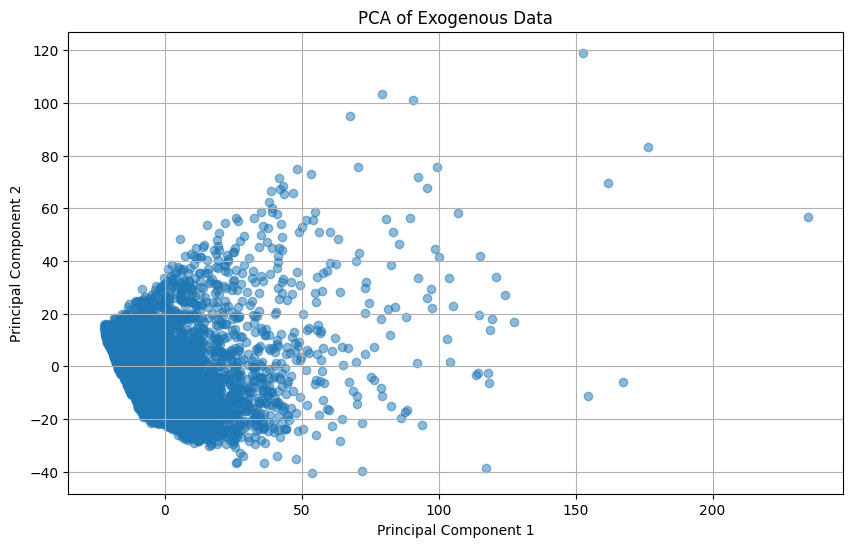

Principal Component 1: 15.92%
Principal Component 2: 9.36%
Principal Component 3: 6.72%
Principal Component 4: 5.42%
Principal Component 5: 3.70%
Principal Component 6: 2.88%
Principal Component 7: 2.41%
Principal Component 8: 1.96%
Principal Component 9: 1.74%
Principal Component 10: 1.69%
sum:  0.5179679123132039


In [74]:
# Standardize the data
scaler = StandardScaler()
exog_data_standardized = scaler.fit_transform(exog_data_daily)


# Number of principal components to keep
n_components = 10  # Adjust this number as needed

# Fit PCA model
pca = PCA(n_components)  # Number of components can be adjusted
principalComponents = pca.fit_transform(exog_data_standardized)

principal_component_labels = [f'Principal Component {i+1}' for i in range(n_components)]
combined_principal_df = pd.DataFrame(data=principalComponents, columns=principal_component_labels, index=exog_data_daily.index)
print(combined_principal_df)

plt.figure(figsize=(10, 6))
plt.scatter(combined_principal_df['Principal Component 1'], combined_principal_df['Principal Component 2'], alpha=0.5)
plt.title('PCA of Exogenous Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Display explained variance
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance * 100:.2f}%")
print("sum: ", sum(explained_variance))



In [75]:

# Combine the PCA DataFrame with alignedDf['Price Per ML ($)']
NEW_PCA_COMBINED_DF = combined_principal_df.join(finalDf['Price Per ML ($)'], how='inner')
print(NEW_PCA_COMBINED_DF)



            Principal Component 1  Principal Component 2  \
2010-01-02             -10.295110              13.980839   
2010-01-02             -10.295110              13.980839   
2010-01-02             -10.295110              13.980839   
2010-01-03             -16.965035               8.627175   
2010-01-09             -20.596512              12.967385   
...                           ...                    ...   
2023-12-21             -13.303088               8.851244   
2023-12-21             -13.303088               8.851244   
2023-12-22             -13.175093              10.735347   
2023-12-22             -13.175093              10.735347   
2023-12-22             -13.175093              10.735347   

            Principal Component 3  Principal Component 4  \
2010-01-02               6.370071              18.486067   
2010-01-02               6.370071              18.486067   
2010-01-02               6.370071              18.486067   
2010-01-03               8.157100      

In [76]:

# Assuming 'Create_date' is the column to align by and it is already the index
finalDf.index = pd.to_datetime(finalDf.index)

# Ensure it's tz-naive
finalDf.index = finalDf.index.tz_localize(None)

# Join the datasets
alignedDf = finalDf.join(exog_data_daily, how='inner')  # 'inner' to keep only matched indices



# Check for any remaining NaN values and drop if necessary
alignedDf.dropna(axis=1, inplace=True)

# Now you can proceed with your analysis



columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal']

alignedDf = alignedDf.drop(columns=columns_to_exclude, errors='ignore')  # errors='ignore' to handle any missing columns gracefully

print(alignedDf)



            Volume Traded (ML)  Price Per ML ($)  2122518    2122711  2122713  \
2010-01-02                70.0            1750.0    21.14  22.786667   20.190   
2010-01-02                63.0            1750.0    21.14  22.786667   20.190   
2010-01-02                33.0            1750.0    21.14  22.786667   20.190   
2010-01-03               109.0            1825.0    21.14  22.173333   20.190   
2010-01-09               140.0            1900.0    21.14  24.636667   20.190   
...                        ...               ...      ...        ...      ...   
2023-12-21                 2.0            7500.0     0.00  20.475000   18.935   
2023-12-21                 3.0            6650.0     0.00  20.475000   18.935   
2023-12-22                 2.2            7250.0     0.00  20.345000   18.655   
2023-12-22                 2.0            7500.0     0.00  20.345000   18.655   
2023-12-22                 1.7            7500.0     0.00  20.345000   18.655   

              2122725   215

# Sarimax with correct plotting time and splitting into test/train

## Is there seasonality? Lets check

<Figure size 1200x600 with 0 Axes>

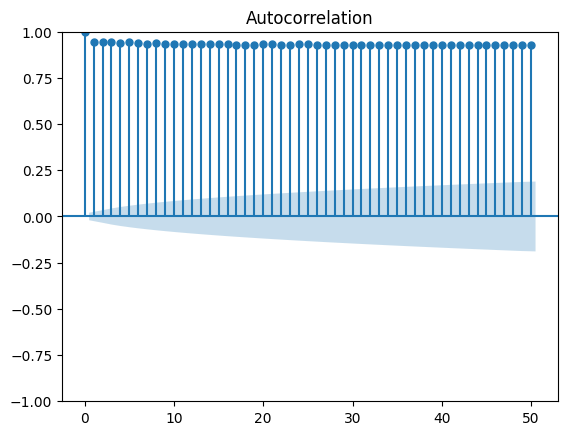

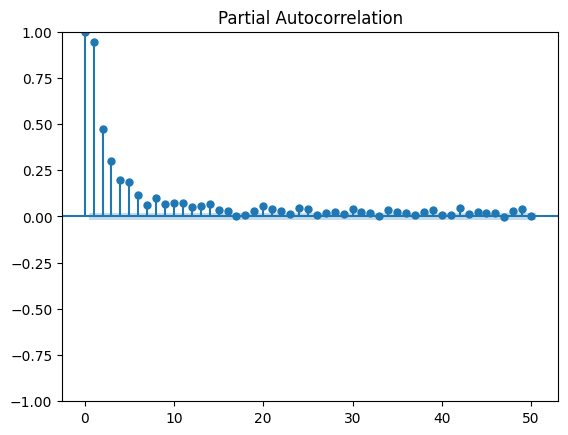

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(NEW_PCA_COMBINED_DF['Price Per ML ($)'], lags=50)
plot_pacf(NEW_PCA_COMBINED_DF['Price Per ML ($)'], lags=50)
plt.show()







## Plotting SARIMAX with ratio of training and test data

/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00725D+00    |proj g|=  8.02948D-01

At iterate    5    f=  7.67506D+00    |proj g|=  2.19606D-02

At iterate   10    f=  7.66727D+00    |proj g|=  9.66367D-03

At iterate   15    f=  7.66693D+00    |proj g|=  1.39870D-02

At iterate   20    f=  7.66321D+00    |proj g|=  2.81448D-02

At iterate   25    f=  7.65932D+00    |proj g|=  1.24013D-03

At iterate   30    f=  7.65929D+00    |proj g|=  1.29121D-03

At iterate   35    f=  7.65911D+00    |proj g|=  7.58630D-04

At iterate   40    f=  7.65910D+00    |proj g|=  5.75634D-04

At iterate   45    f=  7.65898D+00    |proj g|=  3.19394D-03

At iterate   50    f=  7.65863D+00    |proj g|=  4.79510D-03

At iterate   55    f=  7.65858D+00    |proj g|=  2.57303D-04

At iterate   60    f=  7.65858D+00    |proj g|=  1.27589D-03

At iterate   65    f=  7.6

/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


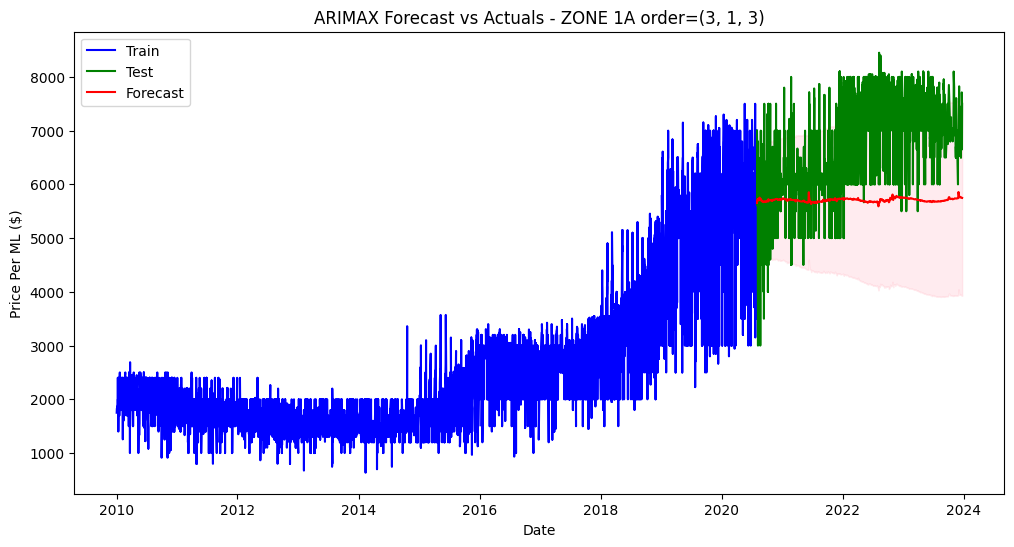

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Price Per ML ($)   No. Observations:                 7416
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -56774.977
Date:                Tue, 14 May 2024   AIC                         113583.954
Time:                        20:56:35   BIC                         113701.445
Sample:                             0   HQIC                        113624.323
                               - 7416                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Principal Component 1     -0.0078      1.361     -0.006      0.995      -2.676       2.661
Principal Component 2      0.4826      1.274      0.379      0.705      -2.015       2.980
Principal Component 3      1.2188      2.233      0.546      0.585      -3.157       5.595
Principal Component 4      1.2148      9.077      0.134      0.894     -16.576      19.005
Principal Component 5     -0.1003      1.631     -0.061      0.951      -3.297       3.097
Principal Component 6      2.0936      1.908      1.097      0.273      -1.646       5.833
Principal Component 7     -0.3603      6.149     -0.059      0.953     -12.411      11.691
Principal Component 8      0.9558      4.532      0.211      0.833      -7.928       9.839
Principal Component 9     -1.3031      3.840     -0.339      0.734      -8.830       6.224
Principal Component 10    -1.2904      4.368     -0.295      0.768      -9.852       7.271
ar.L1                      1.8902      0.018    106.680      0.000       1.855       1.925
ar.L2                     -0.9022      0.026    -35.312      0.000      -0.952      -0.852
ar.L3                      0.0011      0.009      0.129      0.897      -0.016       0.019
ma.L1                     -2.7529      0.017   -164.249      0.000      -2.786      -2.720
ma.L2                      2.5213      0.033     76.291      0.000       2.457       2.586
ma.L3                     -0.7680      0.016    -46.938      0.000      -0.800      -0.736
sigma2                  2.616e+05      0.002   1.59e+08      0.000    2.62e+05    2.62e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10772.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               9.04   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.6e+23. Standard errors may be unstable.
"""

In [78]:
# Convert back to datetime
NEW_PCA_COMBINED_DF.index = pd.to_datetime(NEW_PCA_COMBINED_DF.index)

train_size = int(len(NEW_PCA_COMBINED_DF) * 0.8)  # 80% for training
train, test = NEW_PCA_COMBINED_DF[:train_size], NEW_PCA_COMBINED_DF[train_size:]

# Separate dependent and independent variables
y_train = train['Price Per ML ($)']
X_train = train.drop(columns=['Price Per ML ($)'])
y_test = test['Price Per ML ($)']
X_test = test.drop(columns=['Price Per ML ($)'])


model = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=X_train,  # Exclude target variable from exog
    order=(3, 1, 3),
    #seasonal_order=(1, 0, 1, 365)
)


results = model.fit(method='lbfgs', maxiter=1000)

# 2. Powell's Method
#results = model.fit(method='powell', maxiter=1000)



forecast_steps = len(test)  # Forecast for the length of the test set
forecast_exog = X_test.iloc[:forecast_steps][principal_component_labels]  # Ensure the same exog columns
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_ci = forecast.conf_int()


# Align the forecast with the test data index
forecast_index = test.index


plt.figure(figsize=(12, 6))

# Plot observed data
plt.plot(train.index, train['Price Per ML ($)'], label='Train', color='blue')

# Plot test data
plt.plot(test.index, test['Price Per ML ($)'], label='Test', color='green')

# Plot forecasted data
plt.plot(forecast_index, forecast.predicted_mean, color='r', label='Forecast')

plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMAX Forecast vs Actuals - ZONE 7 order=(3, 1, 3)')
plt.xlabel('Date')
plt.ylabel('Price Per ML ($)')
plt.legend()
plt.show()

results.summary()


In [79]:




# Assume you're using 'Price Per ML ($)' as the dependent variable
model = sm.tsa.statespace.SARIMAX(
    NEW_PCA_COMBINED_DF['Price Per ML ($)'],
    exog=NEW_PCA_COMBINED_DF.drop(columns=['Price Per ML ($)']),  # Exclude target variable from exog
    order=(2, 0, 2),
    #seasonal_order=(1, 0, 1, 12)
)
results = model.fit()

# Forecasting, plotting, etc., as needed.


forecast_steps = 2000  # Forecast for 6 months (approx. 180 days)
forecast_exog = finalDf.drop(columns=['Price Per ML ($)']).iloc[-forecast_steps:][principal_component_labels]  # Ensure the same exog columns
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_ci = forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(NEW_PCA_COMBINED_DF.index, NEW_PCA_COMBINED_DF['Price Per ML ($)'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast.predicted_mean.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.9)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price Per ML ($)')
plt.legend()
plt.show()



/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63142D+01    |proj g|=  3.72540D+01


 This problem is unconstrained.



At iterate    5    f=  7.88183D+00    |proj g|=  9.78118D-02

At iterate   10    f=  7.82176D+00    |proj g|=  1.13413D-02

At iterate   15    f=  7.80386D+00    |proj g|=  1.77862D-02

At iterate   20    f=  7.79298D+00    |proj g|=  1.68565D-03

At iterate   25    f=  7.77248D+00    |proj g|=  6.85674D-03

At iterate   30    f=  7.73552D+00    |proj g|=  3.21815D-03

At iterate   35    f=  7.72768D+00    |proj g|=  4.67044D-03

At iterate   40    f=  7.71653D+00    |proj g|=  8.56464D-04

At iterate   45    f=  7.70741D+00    |proj g|=  9.73644D-04

At iterate   50    f=  7.70533D+00    |proj g|=  2.13143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyError: "None of [Index(['Principal Component 1', 'Principal Component 2',\n       'Principal Component 3', 'Principal Component 4',\n       'Principal Component 5', 'Principal Component 6',\n       'Principal Component 7', 'Principal Component 8',\n       'Principal Component 9', 'Principal Component 10'],\n      dtype='object')] are in the [columns]"

In [ ]:
print(combined_data)



                          Time  2122711  215002  215007  215014   215208  \
0    2010-01-01 00:00:00+10:00    0.458   0.000   0.064   0.001    0.000   
1    2010-01-02 00:00:00+10:00    0.394   0.002   0.089   0.000    0.000   
2    2010-01-03 00:00:00+10:00    0.466   0.001   0.157   0.000    0.034   
3    2010-01-04 00:00:00+10:00    0.665   0.001   0.114   0.000    0.050   
4    2010-01-05 00:00:00+10:00    0.624   0.032   0.093   0.004    0.041   
...                        ...      ...     ...     ...     ...      ...   
5109 2023-12-28 00:00:00+10:00   40.762  94.502   6.055   0.029  207.445   
5110 2023-12-29 00:00:00+10:00   10.628  51.224   3.747   0.026  101.668   
5111 2023-12-30 00:00:00+10:00    4.121  29.822   2.769   0.020   55.115   
5112 2023-12-31 00:00:00+10:00    2.221  20.554   2.359   0.015   35.996   
5113 2024-01-01 00:00:00+10:00    1.551  16.716   1.935   0.015   28.126   

      215239  217006  218001  218005  ...  410851  411003  412005  412045  \
0      0.0

In [ ]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt


def build_sarimax_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']
    return forecast_mean, conf_intervals

# Assuming the 'Price Per ML ($)' column contains the data of interest
series_data = combined_data.set_index('Create_date_ordinal')['Price Per ML ($)']

# Split data into training and testing sets using train_test_split
# Note: shuffle=False is crucial for time series data to maintain the temporal order
train_data, test_data = train_test_split(series_data, test_size=0.3, shuffle=False)

# Build ARMA model on training data
sarimax_model = build_sarimax_model(train_data, order=(10, 1, 10), seasonal_order=(1, 0, 1, 12))

# Simulate future prices on test data
forecast_series, conf_df = forecast_and_simulate(sarimax_model, steps=len(test_data))

# Visualization
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data.index, train_data, label="Training Data", color='blue')

# Plot moving average line using fitted values
plt.plot(train_data.index, sarimax_model.fittedvalues, label="Moving Average", color='purple', linestyle=':')


# Plot testing data
plt.plot(test_data.index, test_data, label="Testing Data", color='red')

# Plot forecasted data
plt.plot(test_data.index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(test_data.index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Date (Ordinal)")
plt.ylabel("Price Per ML ($)")
plt.legend()

# Title and show plot
plt.title("SARIMAX Model Forecast for Price Per ML")
plt.tight_layout()
plt.show()

# Validate model parameters and convergence
if not sarimax_model.mle_retvals['converged']:
    print("Warning: Model did not converge. Check model parameters and data.")
else:
    print("Model converged successfully.")


# Validate forecast intervals
if conf_df['lower'].isnull().any() or conf_df['upper'].isnull().any():
    print("Warning: Confidence intervals contain null values. Check forecast outputs.")
else:
    print("Confidence intervals generated successfully.")
# Display model fit summary
print("Model Summary:")
print(sarimax_model.summary())

# Calculate and display error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors on the test data
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

from sklearn.metrics import r2_score
r_squared = r2_score(test_data, forecast_series)
print("R-squared:", r_squared)


KeyError: "None of ['Create_date_ordinal'] are in the columns"